In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from attrdict import AttrDict

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [7]:
tree = Tree(fc.eightb.preselection_golden.Bkg_MC_List)

In [22]:
def build_variables(tree):
    hij_detas = [ (tree[f'{hi}_eta']-tree[f'{hj}_eta'])**2 for i,hi in enumerate(eightb.higgslist) for hj in eightb.higgslist[i+1:] ]
    h_detasum = hij_detas[0]
    for hij_deta in hij_detas[1:]: h_detasum = h_detasum + hij_deta
    h_detasum = np.sqrt(h_detasum)
    
    bjet_btags = [ tree[f'{b}_btag'] for b in eightb.quarklist ]
    n_medium_btag = ak.zeros_like(bjet_btags[0])
    for bjet_btag in bjet_btags:
        n_medium_btag = n_medium_btag + 1*(bjet_btag > jet_btagWP[2])

    tree.extend(h_detasum=h_detasum, n_medium_btag=n_medium_btag)

build_variables(tree)

(<Figure size 960x400 with 2 Axes>,
 array([<AxesSubplot:xlabel='h_detasum', ylabel='Events'>,
        <AxesSubplot:xlabel='n_medium_btag', ylabel='Events'>],
       dtype=object))

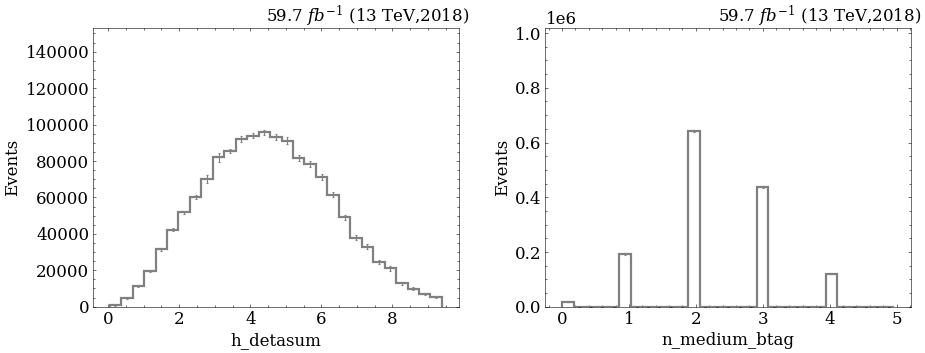

In [24]:
study.quick([tree],varlist=['h_detasum','n_medium_btag'])

In [25]:
target_region = tree.n_medium_btag >= 4
estimation_region = ~target_region

In [26]:
signal_region = tree.h_detasum < 4
control_region = (tree.h_detasum > 4) & (tree.h_detasum < 8)
validation_region = tree.h_detasum > 8

In [46]:
variables = [ f'{obj}_m' for obj in ['X']+eightb.ylist+eightb.higgslist ] + [ f'{obj}_pt' for obj in ['X']+eightb.ylist+eightb.higgslist+eightb.quarklist ] + ['scale']

In [47]:
features = tree[variables]
features = ak.concatenate([ feature[:,None] for feature in ak.unzip(features) ],axis=-1).to_numpy()

In [85]:
target_features = features[target_region & control_region]
estimation_features = features[estimation_region & control_region]

In [86]:
from hep_ml import reweight

transfer_factor = np.sum(target_features[:,-1])/np.sum(estimation_features[:,-1])
estimation_weights = transfer_factor * estimation_features[:,-1]
target_weights = target_features[:,-1]

In [87]:
rnd_seed = 123456
np.random.seed(rnd_seed) # the seed is set through numpy arrays
reweighter_base = reweight.GBReweighter      (n_estimators=10, learning_rate=0.1, max_depth=2, min_samples_leaf=5, gb_args={'subsample': 0.6} )
reweighter      = reweight.FoldingReweighter (reweighter_base, random_state = rnd_seed, n_folds = 2, verbose = True)

In [88]:
reweighter.fit(estimation_features[:,:-1], target_features[:,:-1], estimation_weights, target_weights)

FoldingReweighter(base_reweighter=GBReweighter(gb_args={'subsample': 0.6},
                                               learning_rate=0.1, max_depth=2,
                                               min_samples_leaf=5,
                                               n_estimators=10),
                  random_state=123456)

In [89]:
estimation_features = features[estimation_region & signal_region]
target_features = features[target_region & signal_region]

estimation_weights = transfer_factor * estimation_features[:,-1]
target_weights = target_features[:,-1]

In [90]:
ws      = reweighter.predict_weights (estimation_features[:,:-1], estimation_weights, lambda x: np.mean(x, axis=0) )
weights = np.multiply(ws, transfer_factor)
factor  = float( float(np.sum(target_weights)) / weights.sum()  ) 

KFold prediction with voting function


In [91]:
len(variables)

23

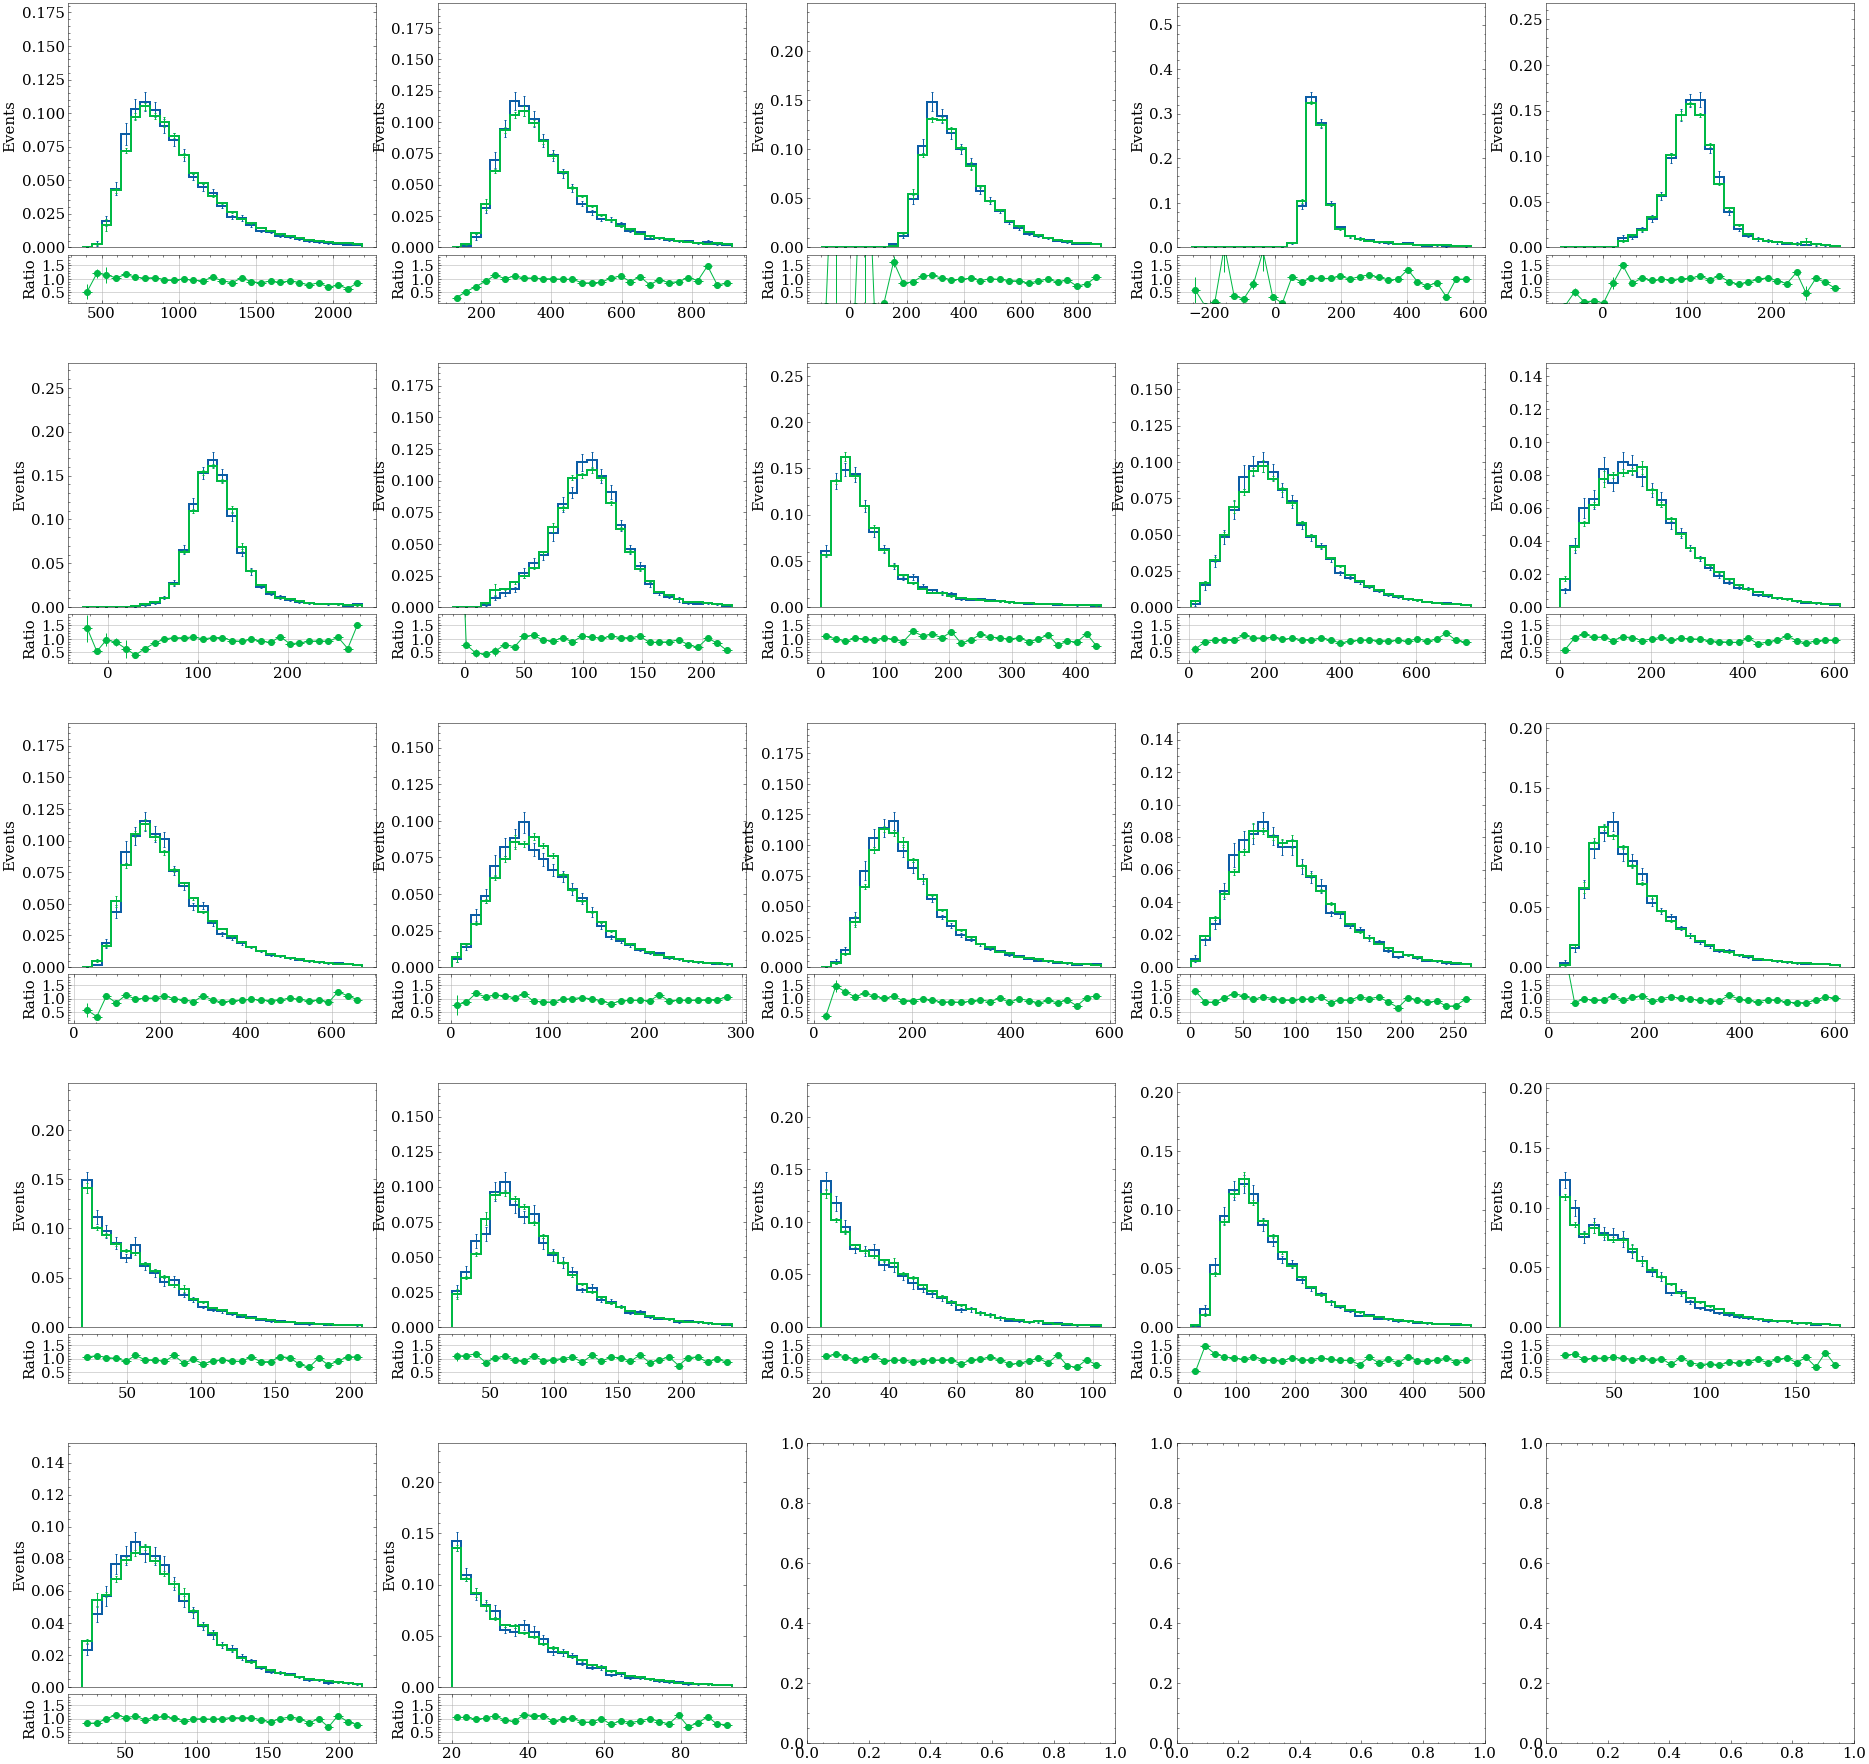

In [92]:
fig,axs=plt.subplots(nrows=5,ncols=5, figsize=(32,32))

for i,variable in enumerate(variables[:-1]):
    hist_multi([target_features[:,i], estimation_features[:,i], ], weights=[target_weights, factor*weights], ratio=True, figax=(fig,axs.flat[i]))